In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data of 39 buildings
df = pd.read_csv('../39个芝加哥办公楼14年6789月.csv')
building_names = df.columns[1:]
load = []
for name in building_names:
    load.append(df[name].values)
load = np.array(load)

# choose one building
data_ori = load[0]

# use max-min normalizaion
maxval = np.max(data_ori)
minval = np.min(data_ori)
data_nor = list(map(lambda x: (x - minval) / (maxval - minval), data_ori))

In [3]:
def naive_dataset(ratio=0.7):
    data_X = data_nor[:-1]
    data_Y = data_nor[1:]
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % 24)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % 24) + train_r
    
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [139]:
[train_X_1, train_Y_1, test_X_1, test_Y_1] = naive_dataset(0.2)

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [140]:
class lstm_1(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_layer=1):
        super(lstm_1, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(1, 24, 10)).cuda()
        c0 = autograd.Variable(torch.zeros(1, 24, 10)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [141]:
model_1 = lstm_1().cuda()
criterion_1 = nn.MSELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-2)

In [142]:
train_x_1 = torch.from_numpy(train_X_1).view(-1, 24, 1).cuda()
train_y_1 = torch.from_numpy(train_Y_1).view(-1, 24, 1).cuda()
test_x_1 = torch.from_numpy(test_X_1).view(-1, 24, 1).cuda()
test_y_1 = torch.from_numpy(test_Y_1).view(-1, 24, 1).cuda()

In [143]:
%%time
for e in range(500):
    var_x = Variable(train_x_1)
    var_y = Variable(train_y_1)
    
    out = model_1(var_x)
    loss = criterion_1(out, var_y)

    optimizer_1.zero_grad()
    loss.backward(retain_graph=True)
    optimizer_1.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 0.02255
Epoch: 100, Loss: 0.01771
Epoch: 150, Loss: 0.01342
Epoch: 200, Loss: 0.01207
Epoch: 250, Loss: 0.01138
Epoch: 300, Loss: 0.01127
Epoch: 350, Loss: 0.01123
Epoch: 400, Loss: 0.01119
Epoch: 450, Loss: 0.01111
Epoch: 500, Loss: 0.01169
Wall time: 2min 16s


In [10]:
# parameters:
ifs = 24   # input feature size = 1
hfs = 30  # hidden feature size = 10
pfs =24   # predict feature size = 1
mbs = 1

In [11]:
def multi_pred_navie_dataset(ratio=0.7):
    data_X = []
    data_Y = []
    
    for i in range(len(data_nor)-pfs):
        if (i+24) % 24 == 0:
            data_X.append(data_nor[i:i+pfs])
            data_Y.append(data_nor[i+1:i+pfs+1])
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % mbs)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % mbs) + train_r
        
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [12]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)

In [13]:
class lstm(nn.Module):
    def __init__(self, input_size=24, hidden_size=30, output_size=24, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(self.num_layer, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [14]:
model = lstm().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [15]:
train_x = torch.from_numpy(train_X).view(-1, mbs, ifs).cuda()
train_y = torch.from_numpy(train_Y).view(-1, mbs,pfs).cuda()
test_x = torch.from_numpy(test_X).view(-1, mbs, ifs).cuda()
test_y = torch.from_numpy(test_Y).view(-1, mbs, pfs).cuda()

In [16]:
%%time
for e in range(800):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 0.01243
Epoch: 100, Loss: 0.00729
Epoch: 150, Loss: 0.00450
Epoch: 200, Loss: 0.00241
Epoch: 250, Loss: 0.00147
Epoch: 300, Loss: 0.00102
Epoch: 350, Loss: 0.00074
Epoch: 400, Loss: 0.00055
Epoch: 450, Loss: 0.00052
Epoch: 500, Loss: 0.00035
Epoch: 550, Loss: 0.00030
Epoch: 600, Loss: 0.00025
Epoch: 650, Loss: 0.00021
Epoch: 700, Loss: 0.00022
Epoch: 750, Loss: 0.00014
Epoch: 800, Loss: 0.00006
Wall time: 6min 36s


In [17]:
import matplotlib.pyplot as plt

In [71]:
model = model.eval()
pred_tensor = model(Variable(test_x))
pred_test = pred_tensor.view(-1).cpu()

In [72]:
pred = pred_test.detach().numpy()
real = test_y.view(-1).cpu().detach().numpy()

In [73]:
diff = []
for i in range(len(real)):
    diff.append((real[i] - pred[i])**2)
print(sum(diff) / len(diff))

0.00919872608020712


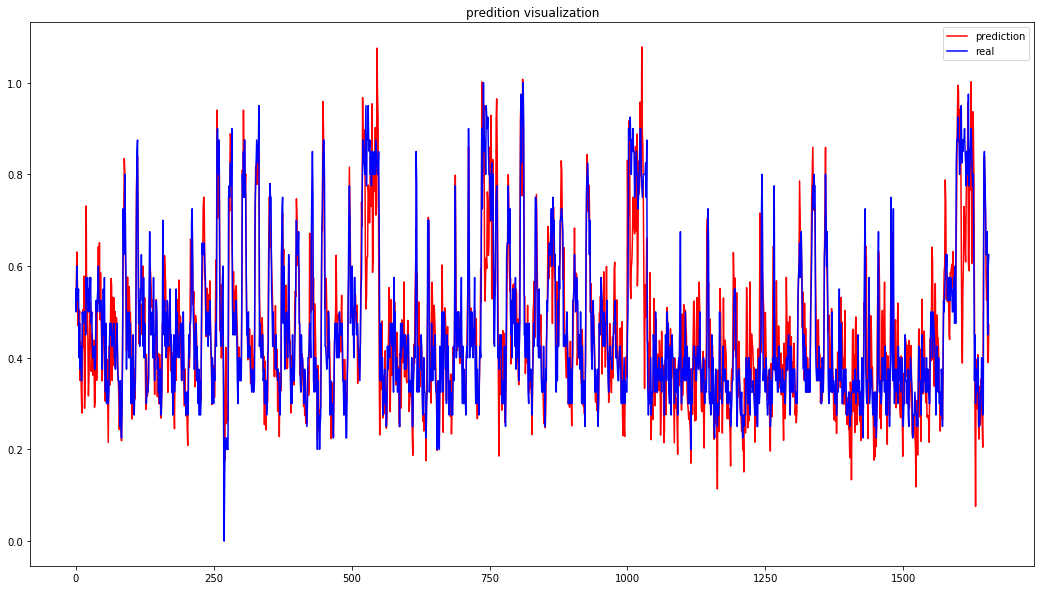

In [74]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(pred, 'r', label='prediction')
plt.plot(real, 'b', label='real')
plt.legend(loc='best')

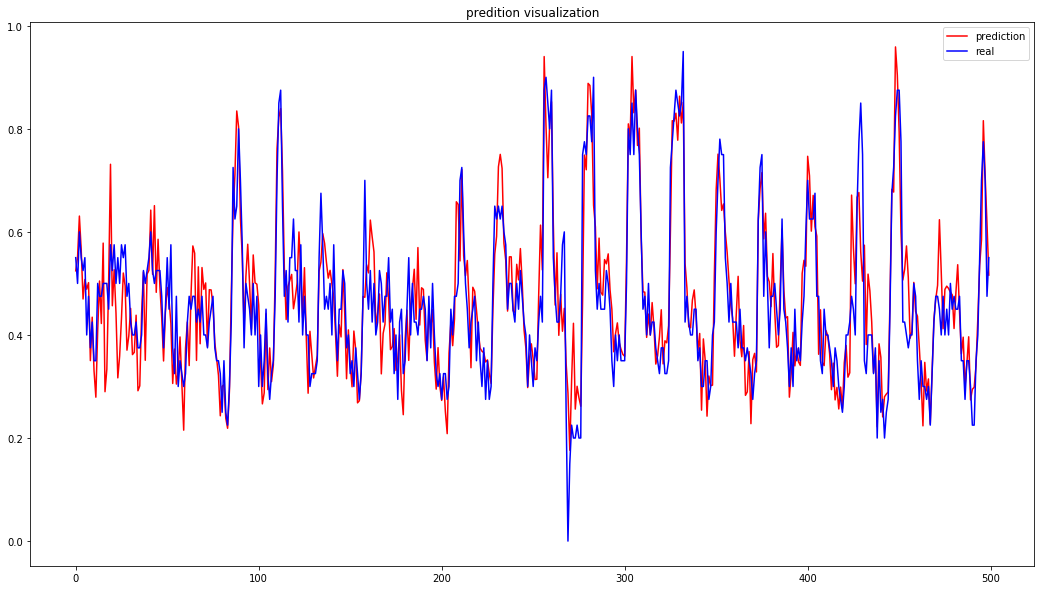

In [75]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(range(500), pred[:500], 'r', label='prediction')
plt.plot(range(500), real[:500], 'b', label='real')
plt.legend(loc='best')

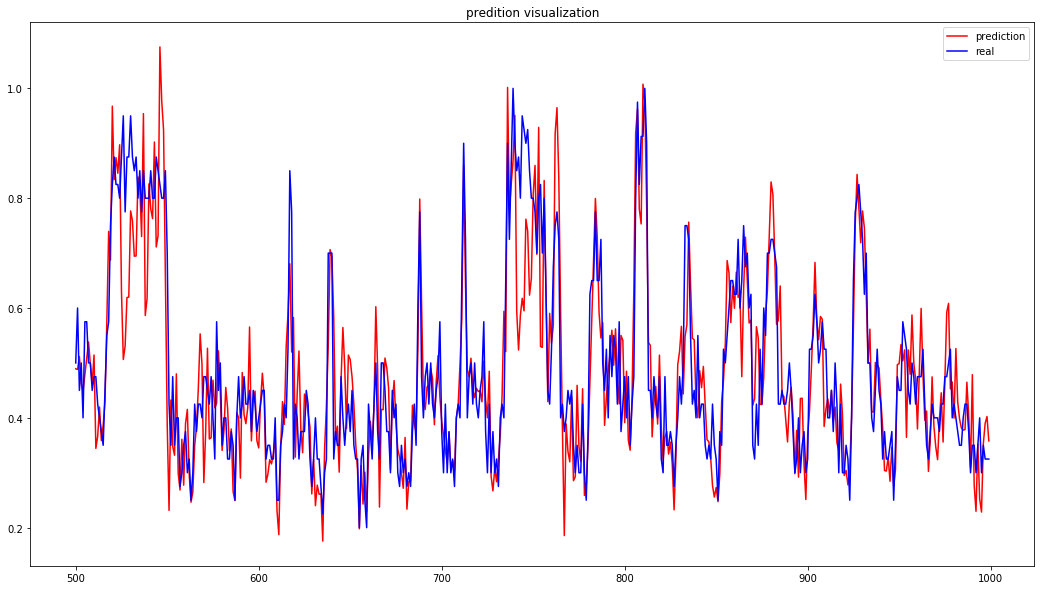

In [76]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(range(500,1000), pred[500:1000], 'r', label='prediction')
plt.plot(range(500,1000), real[500:1000], 'b', label='real')
plt.legend(loc='best')

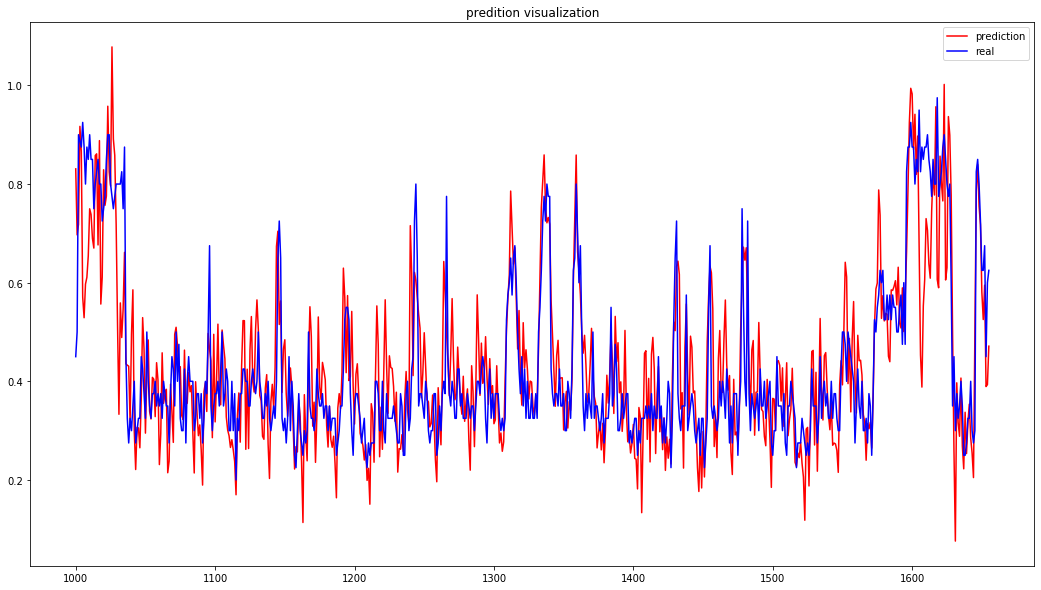

In [77]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(range(1000,len(pred)), pred[1000:], 'r', label='prediction')
plt.plot(range(1000,len(real)), real[1000:], 'b', label='real')
plt.legend(loc='best')

In [78]:
p = model(Variable(test_x)).cpu().detach().numpy()
r = test_y.cpu().detach().numpy()

p = p.reshape(p.shape[0] * p.shape[1], p.shape[2])
r = r.reshape(r.shape[0] * r.shape[1], r.shape[2])

In [79]:
psum, rsum, pmax, rmax, pmin, rmin = [], [], [], [], [], []

for i in range(p.shape[0]):
    psum.append(sum(p[i]))
    rsum.append(sum(r[i]))
    
    pmax.append(max(p[i]))
    rmax.append(max(r[i]))
    
    pmin.append(min(p[i]))
    rmin.append(min(r[i]))

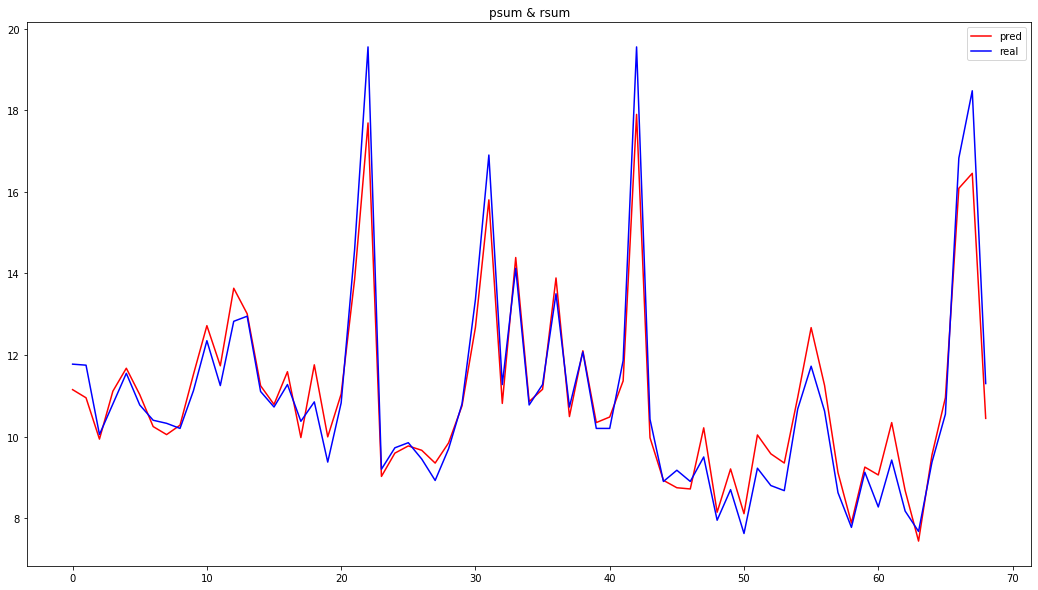

In [80]:
plt.figure(figsize=(18, 10))
plt.title('psum & rsum')
plt.plot(psum, 'r', label='pred')
plt.plot(rsum, 'b', label='real')
plt.legend(loc='best')

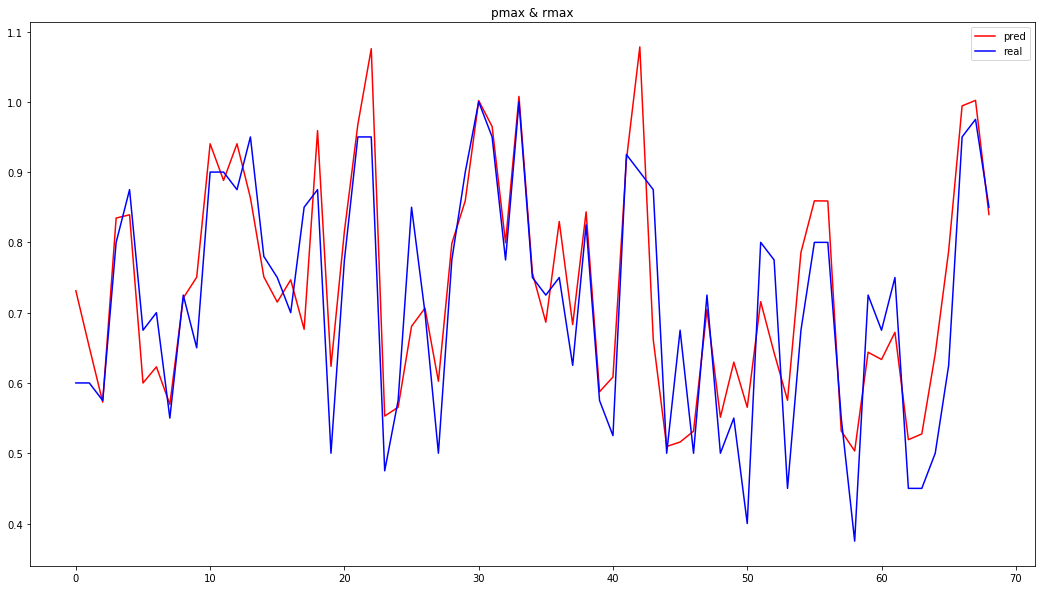

In [81]:
plt.figure(figsize=(18, 10))
plt.title('pmax & rmax')
plt.plot(pmax, 'r', label='pred')
plt.plot(rmax, 'b', label='real')
plt.legend(loc='best')

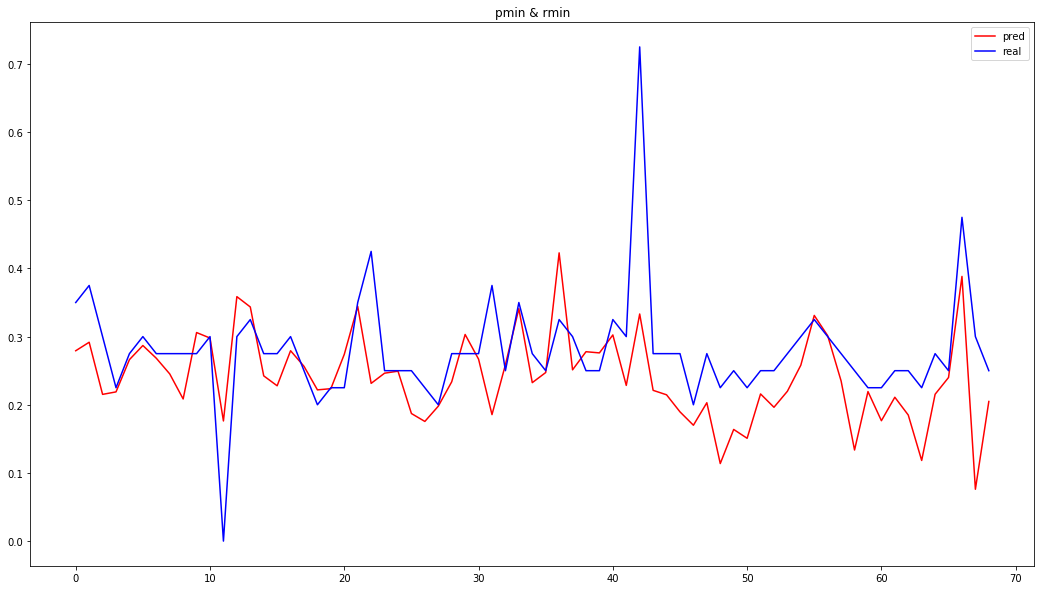

In [82]:
plt.figure(figsize=(18, 10))
plt.title('pmin & rmin')
plt.plot(pmin, 'r', label='pred')
plt.plot(rmin, 'b', label='real')
plt.legend(loc='best')

In [83]:
sumdiff = 0
for i in range(len(psum)):
    sumdiff += (psum[i] - rsum[i]) ** 2
    
sumdiff / len(psum)

0.37384626252949726

In [84]:
maxdiff = 0
for i in range(len(pmax)):
    maxdiff += (pmax[i] - rmax[i]) ** 2
    
maxdiff / len(pmax)

0.007112872650746084

In [85]:
mindiff = 0
for i in range(len(pmax)):
    mindiff += (pmin[i] - rmin[i]) ** 2
    
mindiff / len(pmin)

0.006902708254872685

In [144]:
model_1.eval()
pred_train = torch.from_numpy(pred).view(-1, 24, 1).cuda()
pred_tensor_1 = model_1(Variable(pred_train))
pred_1 = pred_tensor_1.view(-1).cpu().detach().numpy()

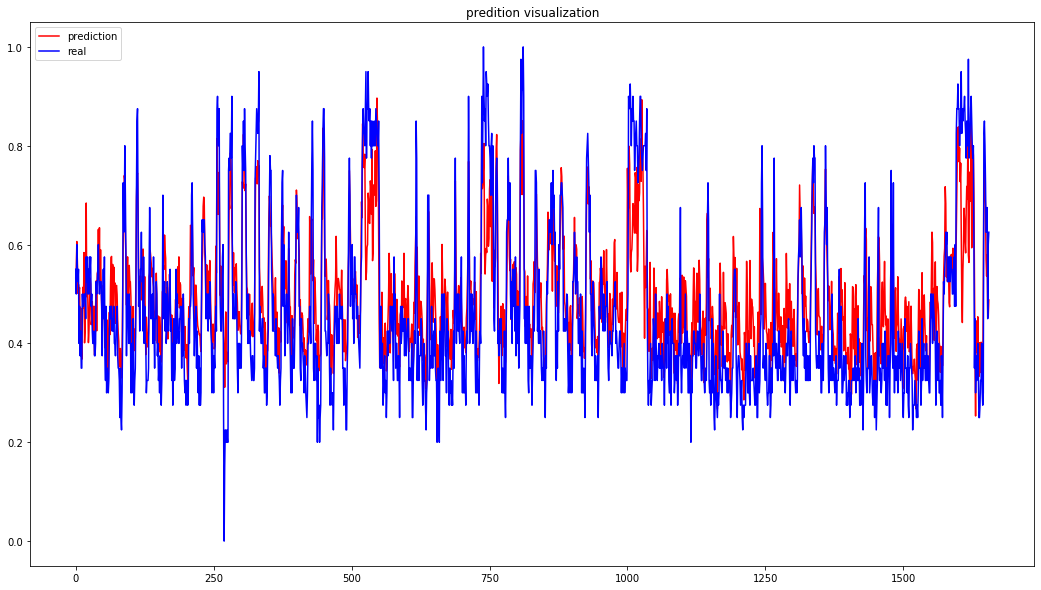

In [145]:
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(pred_1, 'r', label='prediction')
plt.plot(real, 'b', label='real')
plt.legend(loc='best')

In [166]:
pred_2 = []
pred_2.append(pred[0])
for i in range(1, len(pred)):
    pred_2.append(pred[i] + (pred_1[i-1] - pred[i]) / 5)

In [167]:
diff = []
for i in range(len(real)):
    diff.append((real[i] - pred[i])**2)
print(sum(diff) / len(diff))

0.00919872608020712


In [168]:
diff_1 = []
for i in range(len(real)):
    diff.append((real[i] - pred_2[i])**2)
print(sum(diff) / len(diff))

0.008668252873220024


In [169]:
p = np.array(pred_2).reshape(-1, 24)
r = np.array(real).reshape(-1, 24)

psum, rsum, pmax, rmax, pmin, rmin = [], [], [], [], [], []

for i in range(p.shape[0]):
    psum.append(sum(p[i]))
    rsum.append(sum(r[i]))
    
    pmax.append(max(p[i]))
    rmax.append(max(r[i]))
    
    pmin.append(min(p[i]))
    rmin.append(min(r[i]))

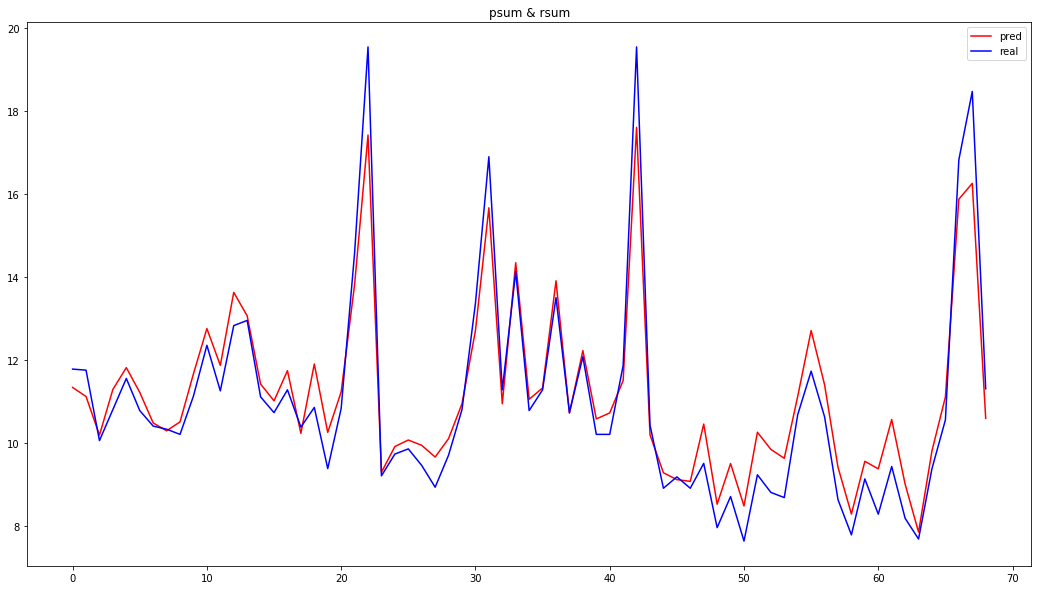

In [170]:
plt.figure(figsize=(18, 10))
plt.title('psum & rsum')
plt.plot(psum, 'r', label='pred')
plt.plot(rsum, 'b', label='real')
plt.legend(loc='best')

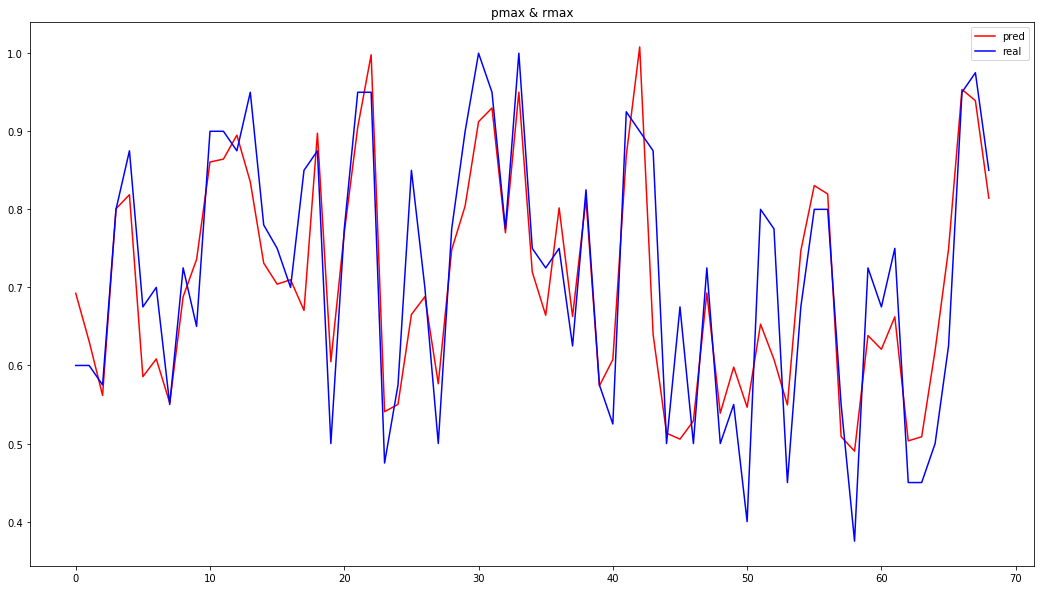

In [172]:
plt.figure(figsize=(18, 10))
plt.title('pmax & rmax')
plt.plot(pmax, 'r', label='pred')
plt.plot(rmax, 'b', label='real')
plt.legend(loc='best')

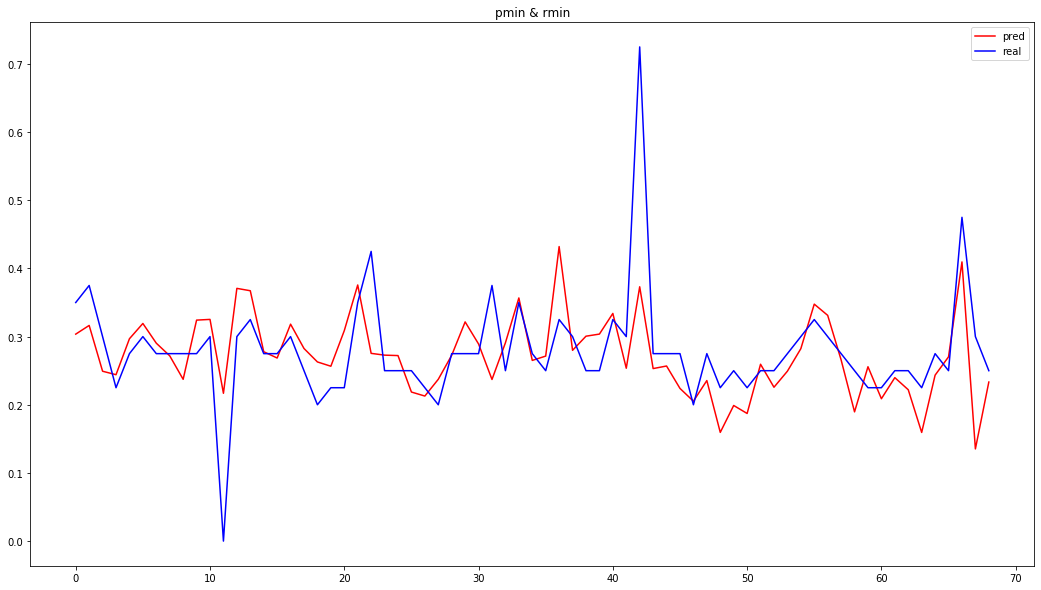

In [173]:
plt.figure(figsize=(18, 10))
plt.title('pmin & rmin')
plt.plot(pmin, 'r', label='pred')
plt.plot(rmin, 'b', label='real')
plt.legend(loc='best')

In [174]:
sumdiff = 0
for i in range(len(psum)):
    sumdiff += (psum[i] - rsum[i]) ** 2
    
sumdiff / len(psum)

0.5302787690790871

In [175]:
maxdiff = 0
for i in range(len(pmax)):
    maxdiff += (pmax[i] - rmax[i]) ** 2
    
maxdiff / len(pmax)

0.006552192836465504

In [176]:
mindiff = 0
for i in range(len(pmax)):
    mindiff += (pmin[i] - rmin[i]) ** 2
    
mindiff / len(pmin)

0.004850060570902466